In [3]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.NeuralNetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Paramaters

In [4]:
base_seed = 42
base_feature_size = 12
baseline_accuracy = 0.925

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [5]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [6]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [7]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 64, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9638020833333334


### Assesing performance

In [8]:
nn_results, unscaled_guarantee = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9585416666666666
Run 2 / 10 started
Run finished with test accuracy: 0.9639583333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9635416666666666
Run 4 / 10 started
Run finished with test accuracy: 0.959375
Run 5 / 10 started
Run finished with test accuracy: 0.9622916666666667
Run 6 / 10 started
Run finished with test accuracy: 0.96375
Run 7 / 10 started
Run finished with test accuracy: 0.9627083333333334
Run 8 / 10 started
Run finished with test accuracy: 0.9579166666666666
Run 9 / 10 started
Run finished with test accuracy: 0.9552083333333333
Run 10 / 10 started
Run finished with test accuracy: 0.9595833333333333


In [9]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.693416        0.507812       0.958542
1     0      1    0.692462        0.516094       0.958542
2     0      2    0.692020        0.520833       0.958542
3     0      3    0.691791        0.524948       0.958542
4     0      4    0.691562        0.527656       0.958542


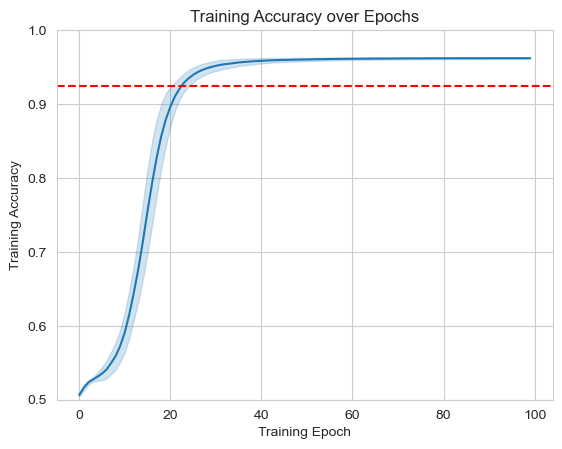

In [10]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

In [11]:
risk_tolerance = nn_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.03568749999999998) <= 0.01


# Random Forrests

In [12]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [13]:
forrest_results, unscaled_guarantee = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9616666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.9683333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9672916666666667
Run 4 / 10 started
Run finished with test accuracy: 0.961875
Run 5 / 10 started
Run finished with test accuracy: 0.9645833333333333
Run 6 / 10 started
Run finished with test accuracy: 0.9670833333333333
Run 7 / 10 started
Run finished with test accuracy: 0.965625
Run 8 / 10 started
Run finished with test accuracy: 0.9629166666666666
Run 9 / 10 started
Run finished with test accuracy: 0.9616666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.963125


In [14]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.961667
1    1       0.968333
2    2       0.967292
3    3       0.961875
4    4       0.964583
5    5       0.967083
6    6       0.965625
7    7       0.962917
8    8       0.961667
9    9       0.963125


In [15]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9644166666666667
Baseline to beat 0.925


In [16]:
risk_tolerance = forrest_results['test_accuracy'].mean() - baseline_accuracy
print(f'P(|E[r] - r_hat| > {risk_tolerance}) <= {unscaled_guarantee / risk_tolerance:.2f}')  

P(|E[r] - r_hat| > 0.039416666666666655) <= 0.01


# Logistic Regression

In [17]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [21]:
params = {
    'alpha': [0.1, 0.15, 0.2],
    'max_iter': [1500],
    'tol': [1e-3],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.001],
}

logreg = SGDClassifier(loss='log_loss', n_jobs=-1)

gs = GridSearchCV(logreg, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [22]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.5521874999999999


### Assessing Performance

In [23]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.5541666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.5397916666666667
Run 3 / 10 started
Run finished with test accuracy: 0.5627083333333334
Run 4 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 5 / 10 started
Run finished with test accuracy: 0.5583333333333333
Run 6 / 10 started
Run finished with test accuracy: 0.5445833333333333
Run 7 / 10 started
Run finished with test accuracy: 0.5308333333333334
Run 8 / 10 started
Run finished with test accuracy: 0.535625
Run 9 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 10 / 10 started
Run finished with test accuracy: 0.5375


In [24]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.554167
1    1       0.539792
2    2       0.562708
3    3       0.551458
4    4       0.558333
5    5       0.544583
6    6       0.530833
7    7       0.535625
8    8       0.551458
9    9       0.537500


In [25]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.5466458333333333
Baseline to beat 0.925
